In [1]:
from src.vrp.utils.getData import GetData
from src.vrp.algorithm.population import Population
from src.vrp.algorithm.genetic import Genetic
from src.vrp.utils.utils import *

import random
import numpy as np

random.seed(42)
np.random.seed(42)

## Cấu hình tham số

In [2]:
DEPOT = "University of Transport and Communications"
NUM_POINTS = 30
MAX_DISTANCE = 10
NUM_VEHICLES = 5

# GA parameters
POPULATION_SIZE = 500
MAX_GENERATIONS = 1000
MUTATION_RATE = 0.01
ELITISM_SIZE = 5

## Hiển thị dữ liệu trên Map

In [3]:
data_generator = GetData(
        location_name=DEPOT, 
        num_random_points=NUM_POINTS,  
        max_distance_km=MAX_DISTANCE
)

locations, distance_matrix = data_generator.run()

In [4]:
map_center = create_map_with_markers(locations, DEPOT)
map_center

## Ma trận khoảng cách giữa các điểm

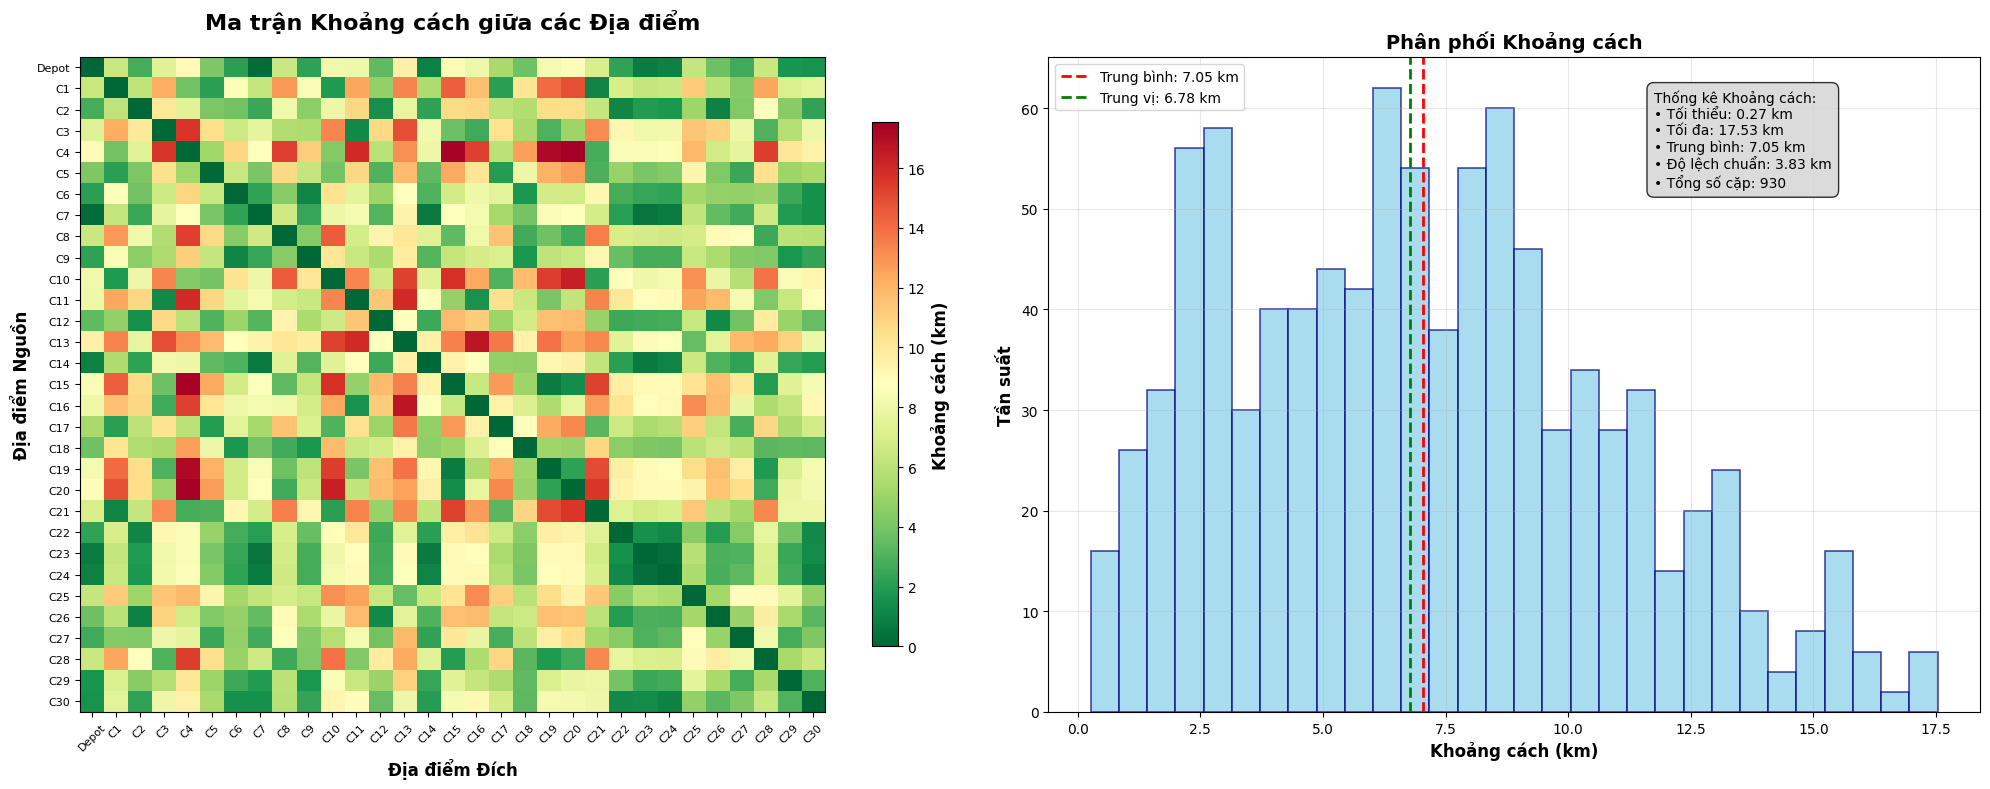

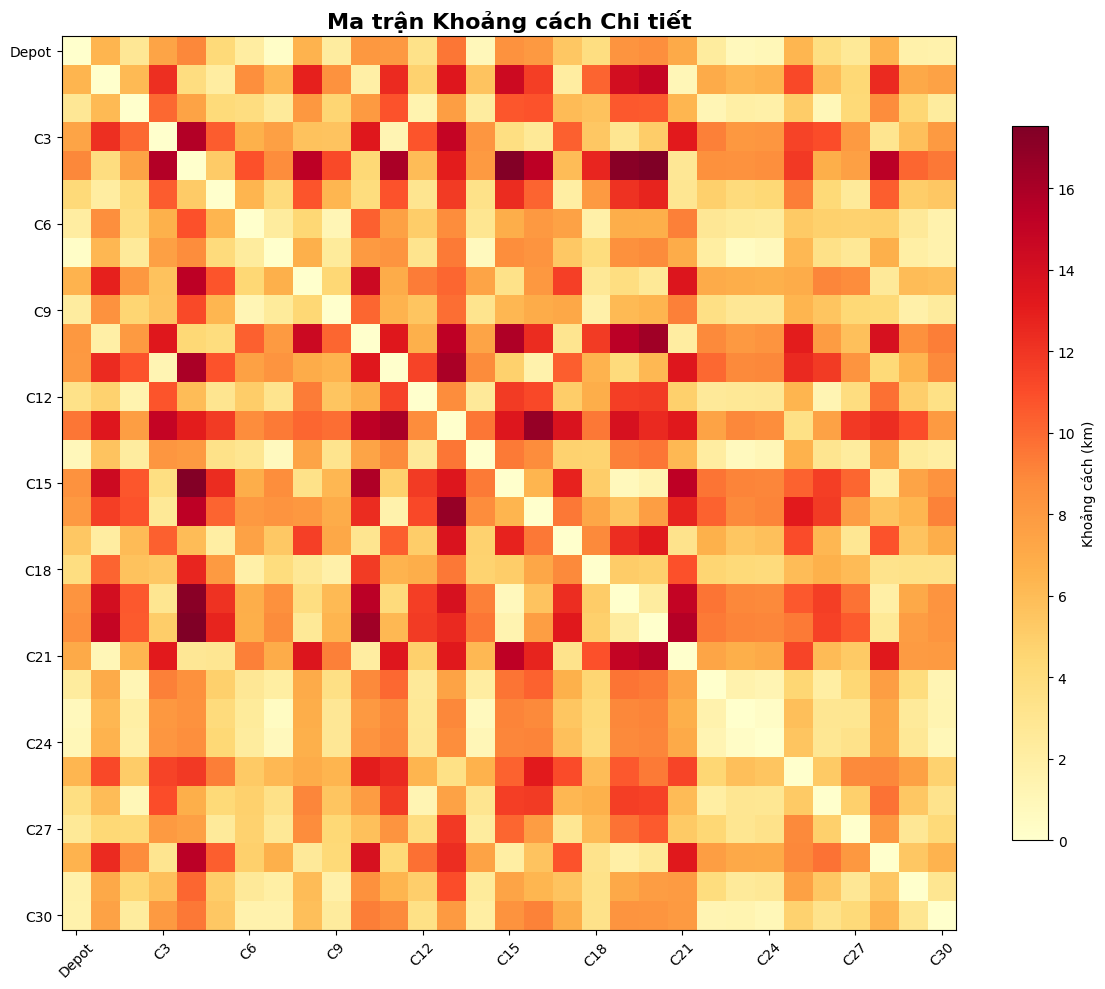

In [5]:
import matplotlib.pyplot as plt

# Convert the distance matrix to a numpy array if it's not already
distance_array = np.array(distance_matrix)

# Create location labels - assuming these are positions 0 to NUM_POINTS
location_labels = ["Depot"] + [f"C{i}" for i in range(1, NUM_POINTS + 1)]

# Create a more professional visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Main heatmap
im1 = ax1.imshow(distance_array, cmap='RdYlGn_r', aspect='auto')
ax1.set_xticks(range(len(distance_array)))
ax1.set_yticks(range(len(distance_array)))
ax1.set_xticklabels(location_labels, rotation=45, fontsize=8)
ax1.set_yticklabels(location_labels, fontsize=8)

# Add colorbar for main heatmap
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
cbar1.set_label('Khoảng cách (km)', fontsize=12, fontweight='bold')

ax1.set_title('Ma trận Khoảng cách giữa các Địa điểm', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Địa điểm Đích', fontsize=12, fontweight='bold')
ax1.set_ylabel('Địa điểm Nguồn', fontsize=12, fontweight='bold')

# Create a summary statistics subplot
distances_flat = distance_array[distance_array > 0]  # Exclude diagonal zeros
ax2.hist(distances_flat, bins=30, alpha=0.7, color='skyblue', edgecolor='navy', linewidth=1.2)
ax2.axvline(distances_flat.mean(), color='red', linestyle='--', linewidth=2, label=f'Trung bình: {distances_flat.mean():.2f} km')
ax2.axvline(np.median(distances_flat), color='green', linestyle='--', linewidth=2, label=f'Trung vị: {np.median(distances_flat):.2f} km')

ax2.set_xlabel('Khoảng cách (km)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Tần suất', fontsize=12, fontweight='bold')
ax2.set_title('Phân phối Khoảng cách', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add statistics text box
stats_text = f"""Thống kê Khoảng cách:
• Tối thiểu: {distances_flat.min():.2f} km
• Tối đa: {distances_flat.max():.2f} km
• Trung bình: {distances_flat.mean():.2f} km
• Độ lệch chuẩn: {distances_flat.std():.2f} km
• Tổng số cặp: {len(distances_flat)}"""

ax2.text(0.65, 0.95, stats_text, transform=ax2.transAxes, fontsize=10,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

# Display detailed distance matrix with values (smaller version for readability)
fig3, ax3 = plt.subplots(figsize=(12, 10))
im3 = ax3.imshow(distance_array, cmap='YlOrRd', aspect='auto')

# Show only every 5th label to avoid overcrowding
step = max(1, len(location_labels) // 10)
tick_positions = range(0, len(location_labels), step)
tick_labels = [location_labels[i] for i in tick_positions]

ax3.set_xticks(tick_positions)
ax3.set_yticks(tick_positions)
ax3.set_xticklabels(tick_labels, rotation=45, fontsize=10)
ax3.set_yticklabels(tick_labels, fontsize=10)

# Add values to cells (only for smaller matrices or sample)
if len(distance_array) <= 15:
    for i in range(len(distance_array)):
        for j in range(len(distance_array)):
            val = distance_array[i, j]
            ax3.text(j, i, f'{val:.1f}',
                    ha="center", va="center",
                    color='white' if val > distance_array.max() / 2 else 'black',
                    fontsize=6)

plt.colorbar(im3, ax=ax3, shrink=0.8, label='Khoảng cách (km)')
ax3.set_title('Ma trận Khoảng cách Chi tiết', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## Khởi tạo quần thể và khởi tạo lộ trình ban đầu

In [6]:
population = Population(
        pop_size=POPULATION_SIZE,
        num_locations=NUM_POINTS,
        num_vehicles=NUM_VEHICLES,
        distance_matrix=distance_matrix
    )

initial_best = population.find_best_chromosome()

In [7]:
import os
from IPython.display import display, HTML

# Make sure the directory exists
static_dir = "./data/static"
os.makedirs(static_dir, exist_ok=True)

# Create initial map with markers and routes
initial_map = data_generator.create_map()
data_generator.add_markers()
draw_routes(initial_map, locations, initial_best.get_routes())

# Save to file
initial_map_path = os.path.join(static_dir, "initial_solution.html")
initial_map.save(initial_map_path)


# Basic solution metrics
routes = initial_best.get_routes()
total_distance = initial_best.calculate_fitness(distance_matrix)

print(f"\n📊 THÔNG TIN CƠ BẢN:")
print(f"   • Tổng khoảng cách: {total_distance:.2f} km")
print(f"   • Số lượng xe: {len(routes)} xe")
print(f"   • Số điểm giao hàng: {NUM_POINTS} điểm")
print(f"   • Fitness score: {1/total_distance:.6f}")

# Route details
print(f"\n🚚 CHI TIẾT CÁC TUYẾN ĐƯỜNG:")
for i, route in enumerate(routes):
    if len(route) > 2:  # Only show routes with actual customers
        route_distance = 0
        for j in range(len(route) - 1):
            route_distance += distance_matrix[route[j]][route[j+1]]
        
        customer_count = len(route) - 2  # Exclude depot start and end
        print(f"   Xe {i+1}: {route}")
        print(f"          Khoảng cách: {route_distance:.2f} km")
        print(f"          Số khách hàng: {customer_count}")
        print(f"          Hiệu quả: {customer_count/route_distance:.2f} khách/km")

# Statistical analysis
route_distances = []
route_customers = []
for route in routes:
    if len(route) > 2:
        route_distance = 0
        for j in range(len(route) - 1):
            route_distance += distance_matrix[route[j]][route[j+1]]
        route_distances.append(route_distance)
        route_customers.append(len(route) - 2)

if route_distances:
    print(f"\n📈 PHÂN TÍCH THỐNG KÊ:")
    print(f"   • Khoảng cách trung bình/tuyến: {np.mean(route_distances):.2f} km")
    print(f"   • Độ lệch chuẩn khoảng cách: {np.std(route_distances):.2f} km")
    print(f"   • Tuyến ngắn nhất: {min(route_distances):.2f} km")
    print(f"   • Tuyến dài nhất: {max(route_distances):.2f} km")
    print(f"   • Khách hàng trung bình/tuyến: {np.mean(route_customers):.1f}")
    print(f"   • Cân bằng tải: {(1 - np.std(route_customers)/np.mean(route_customers)):.2%}")

# Efficiency metrics
total_customers_served = sum(route_customers) if route_customers else 0
efficiency = total_customers_served / total_distance if total_distance > 0 else 0

print(f"\n⚡ CHỈ SỐ HIỆU SUẤT:")
print(f"   • Hiệu suất tổng thể: {efficiency:.3f} khách/km")
print(f"   • Tỷ lệ sử dụng xe: {len([r for r in routes if len(r) > 2])}/{NUM_VEHICLES} ({len([r for r in routes if len(r) > 2])/NUM_VEHICLES:.1%})")
print(f"   • Khoảng cách trung bình/khách: {total_distance/total_customers_served:.2f} km" if total_customers_served > 0 else "   • Khoảng cách trung bình/khách: N/A")

print(f"\n💾 Bản đồ đã được lưu tại: {initial_map_path}")
print("=" * 60)

# Display the map in the notebook
display(HTML(f'<h3>🗺️ Initial Solution Map</h3>'))
display(initial_map)


📊 THÔNG TIN CƠ BẢN:
   • Tổng khoảng cách: 179.87 km
   • Số lượng xe: 5 xe
   • Số điểm giao hàng: 30 điểm
   • Fitness score: 0.005560

🚚 CHI TIẾT CÁC TUYẾN ĐƯỜNG:
   Xe 1: [-1, 1, 0, 26, 8, 5, 22, 13, 6, -1]
          Khoảng cách: 59.89 km
          Số khách hàng: 8
          Hiệu quả: 0.13 khách/km
   Xe 2: [-1, 4, 25, 21, -1]
          Khoảng cách: 40.60 km
          Số khách hàng: 3
          Hiệu quả: 0.07 khách/km
   Xe 3: [-1, 19, 14, 2, 18, 10, 29, -1]
          Khoảng cách: 48.71 km
          Số khách hàng: 6
          Hiệu quả: 0.12 khách/km
   Xe 4: [-1, 11, 15, 23, 28, 12, 17, 7, 3, 24, 16, 9, 20, -1]
          Khoảng cách: 96.39 km
          Số khách hàng: 12
          Hiệu quả: 0.12 khách/km
   Xe 5: [-1, 27, -1]
          Khoảng cách: 8.48 km
          Số khách hàng: 1
          Hiệu quả: 0.12 khách/km

📈 PHÂN TÍCH THỐNG KÊ:
   • Khoảng cách trung bình/tuyến: 50.81 km
   • Độ lệch chuẩn khoảng cách: 28.50 km
   • Tuyến ngắn nhất: 8.48 km
   • Tuyến dài nhất: 96.39 km


## Chạy giải thuật GA để tìm lộ trình tốt nhất

In [8]:
ga = Genetic(
    population=population,
    max_generations=MAX_GENERATIONS,
    mutation_rate=MUTATION_RATE,
    elitism_size=ELITISM_SIZE
)

print("🚀 BẮT ĐẦU THUẬT TOÁN DI TRUYỀN")
print("=" * 60)
print(f"📋 Cấu hình:")
print(f"   • Kích thước quần thể: {POPULATION_SIZE}")
print(f"   • Số thế hệ tối đa: {MAX_GENERATIONS}")
print(f"   • Tỷ lệ đột biến: {MUTATION_RATE}")
print(f"   • Kích thước Elite: {ELITISM_SIZE}")
print(f"   • Fitness ban đầu: {initial_best.calculate_fitness(distance_matrix):.2f} km")
print("=" * 60)

final_solution = ga.run(verbose=True)

print("\n🎯 KẾT QUẢ CUỐI CÙNG")
print("=" * 60)
final_fitness = final_solution.calculate_fitness(distance_matrix)
initial_fitness = initial_best.calculate_fitness(distance_matrix)
improvement = initial_fitness - final_fitness
improvement_percent = (improvement / initial_fitness) * 100

print(f"✅ Tổng khoảng cách cuối: {final_fitness:.2f} km")
print(f"📈 Cải thiện: {improvement:.2f} km ({improvement_percent:.2f}%)")
print(f"🏆 Fitness score: {1/final_fitness:.6f}")

🚀 BẮT ĐẦU THUẬT TOÁN DI TRUYỀN
📋 Cấu hình:
   • Kích thước quần thể: 500
   • Số thế hệ tối đa: 1000
   • Tỷ lệ đột biến: 0.01
   • Kích thước Elite: 5
   • Fitness ban đầu: 179.87 km
Starting genetic algorithm with 500 chromosomes
Initial best fitness: 179.87
Generation 10/1000 - Best: 126.93, Avg: 167.55, Time: 0.14s
Generation 20/1000 - Best: 109.76, Avg: 125.66, Time: 0.26s
Generation 30/1000 - Best: 97.91, Avg: 109.52, Time: 0.38s
Generation 20/1000 - Best: 109.76, Avg: 125.66, Time: 0.26s
Generation 30/1000 - Best: 97.91, Avg: 109.52, Time: 0.38s
Generation 40/1000 - Best: 88.68, Avg: 97.41, Time: 0.52s
Generation 50/1000 - Best: 85.48, Avg: 89.15, Time: 0.63s
Generation 40/1000 - Best: 88.68, Avg: 97.41, Time: 0.52s
Generation 50/1000 - Best: 85.48, Avg: 89.15, Time: 0.63s
Generation 60/1000 - Best: 81.57, Avg: 85.78, Time: 0.80s
Generation 70/1000 - Best: 80.25, Avg: 83.41, Time: 0.91s
Generation 80/1000 - Best: 78.55, Avg: 80.23, Time: 1.01s
Generation 60/1000 - Best: 81.57, A

## Kết quả

In [9]:
final_map = data_generator.create_map()
data_generator.add_markers()
draw_routes(final_map, locations, final_solution.get_routes())
final_map_path = os.path.join(static_dir, "final_solution.html")
final_map.save(final_map_path)

display(HTML(f'<h3>Final Solution Map</h3>'))
display(final_map)


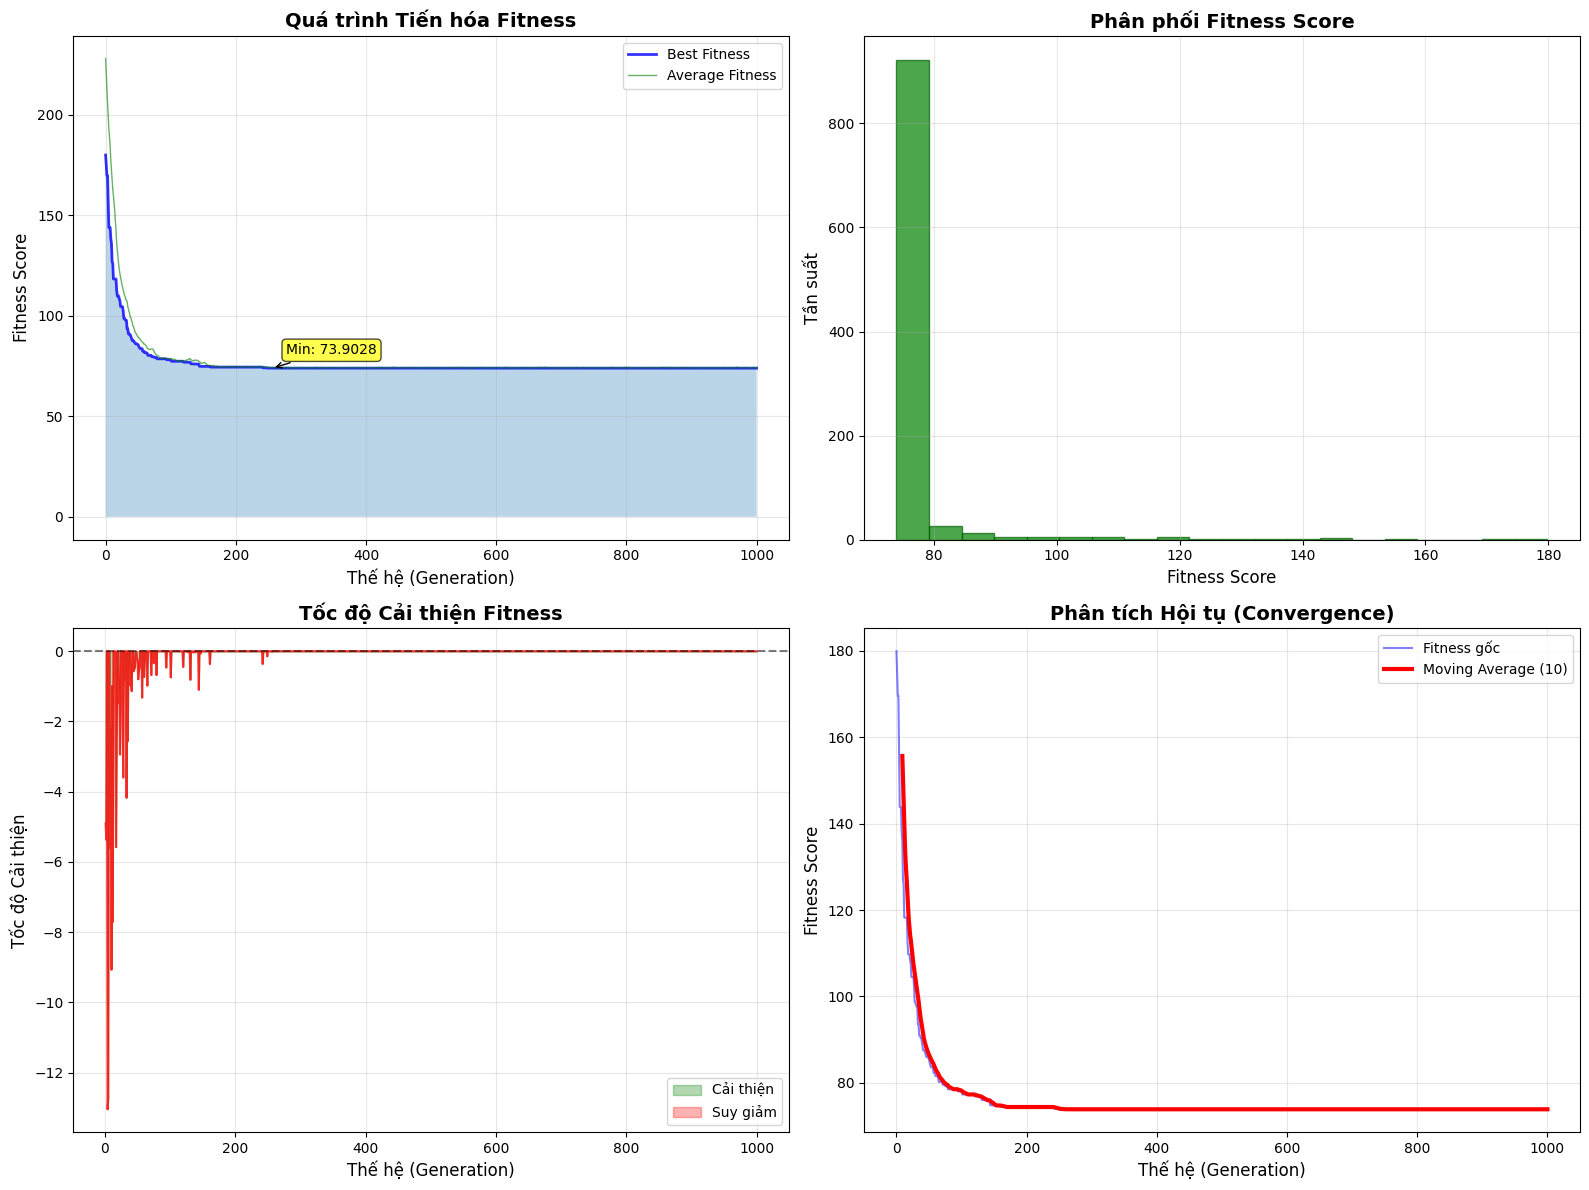


Thống kê quá trình tiến hóa:
Fitness cuối cùng: 73.902761
Fitness cao nhất: 179.868906
Fitness thấp nhất: 73.902761
Fitness trung bình: 76.282272
Độ lệch chuẩn: 10.020431
Tổng cải thiện: 105.966145
Tốc độ cải thiện trung bình: 0.105860/thế hệ


In [10]:
progress = ga.get_progress()

# Create a separate figure for saving
plt_save = plot_evolution_progress(
    progress["best_fitness_history"], 
    progress["avg_fitness_history"]
)
plot_path = os.path.join(static_dir, "fitness_evolution.png")
plt_save.savefig(plot_path)
plt_save.close()

# Create a new figure for the dashboard visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Biểu đồ 1: Tiến hóa Fitness qua các thế hệ
generations = range(len(progress["best_fitness_history"]))
ax1.plot(generations, progress["best_fitness_history"], 'b-', linewidth=2, alpha=0.8, label='Best Fitness')
ax1.plot(generations, progress["avg_fitness_history"], 'g-', linewidth=1, alpha=0.6, label='Average Fitness')
ax1.fill_between(generations, progress["best_fitness_history"], alpha=0.3)
ax1.set_xlabel('Thế hệ (Generation)', fontsize=12)
ax1.set_ylabel('Fitness Score', fontsize=12)
ax1.set_title('Quá trình Tiến hóa Fitness', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Thêm chú thích cho các mốc quan trọng
if len(progress["best_fitness_history"]) > 10:
    min_fitness_idx = np.argmin(progress["best_fitness_history"])
    ax1.annotate(f'Min: {progress["best_fitness_history"][min_fitness_idx]:.4f}', 
                xy=(min_fitness_idx, progress["best_fitness_history"][min_fitness_idx]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Biểu đồ 2: Histogram phân phối Fitness
ax2.hist(progress["best_fitness_history"], bins=20, alpha=0.7, color='green', edgecolor='darkgreen')
ax2.set_xlabel('Fitness Score', fontsize=12)
ax2.set_ylabel('Tần suất', fontsize=12)
ax2.set_title('Phân phối Fitness Score', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Biểu đồ 3: Tốc độ cải thiện (Improvement Rate)
if len(progress["best_fitness_history"]) > 1:
    improvement_rate = np.diff(progress["best_fitness_history"])
    ax3.plot(range(1, len(progress["best_fitness_history"])), improvement_rate, 'r-', alpha=0.8)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Thế hệ (Generation)', fontsize=12)
    ax3.set_ylabel('Tốc độ Cải thiện', fontsize=12)
    ax3.set_title('Tốc độ Cải thiện Fitness', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Tô màu vùng cải thiện và suy giảm
    ax3.fill_between(range(1, len(progress["best_fitness_history"])), improvement_rate, 0, 
                    where=(improvement_rate <= 0), color='green', alpha=0.3, label='Cải thiện')
    ax3.fill_between(range(1, len(progress["best_fitness_history"])), improvement_rate, 0, 
                    where=(improvement_rate > 0), color='red', alpha=0.3, label='Suy giảm')
    ax3.legend()

# Biểu đồ 4: Convergence Analysis
window_size = 10
if len(progress["best_fitness_history"]) > window_size:
    moving_avg = np.convolve(progress["best_fitness_history"], np.ones(window_size)/window_size, mode='valid')
    ax4.plot(generations, progress["best_fitness_history"], 'b-', alpha=0.5, label='Fitness gốc')
    ax4.plot(range(window_size-1, len(progress["best_fitness_history"])), moving_avg, 'r-', 
            linewidth=3, label=f'Moving Average ({window_size})')
    ax4.set_xlabel('Thế hệ (Generation)', fontsize=12)
    ax4.set_ylabel('Fitness Score', fontsize=12)
    ax4.set_title('Phân tích Hội tụ (Convergence)', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.plot(generations, progress["best_fitness_history"], 'b-', linewidth=2)
    ax4.set_title('Fitness Evolution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Thống kê chi tiết về quá trình tiến hóa
print("\nThống kê quá trình tiến hóa:")
print(f"Fitness cuối cùng: {progress['best_fitness_history'][-1]:.6f}")
print(f"Fitness cao nhất: {max(progress['best_fitness_history']):.6f}")
print(f"Fitness thấp nhất: {min(progress['best_fitness_history']):.6f}")
print(f"Fitness trung bình: {np.mean(progress['best_fitness_history']):.6f}")
print(f"Độ lệch chuẩn: {np.std(progress['best_fitness_history']):.6f}")

if len(progress["best_fitness_history"]) > 1:
    total_improvement = abs(progress["best_fitness_history"][-1] - progress["best_fitness_history"][0])
    improvement_rate = total_improvement / len(progress["best_fitness_history"])
    print(f"Tổng cải thiện: {total_improvement:.6f}")
    print(f"Tốc độ cải thiện trung bình: {improvement_rate:.6f}/thế hệ")

## Minh họa thuật toán

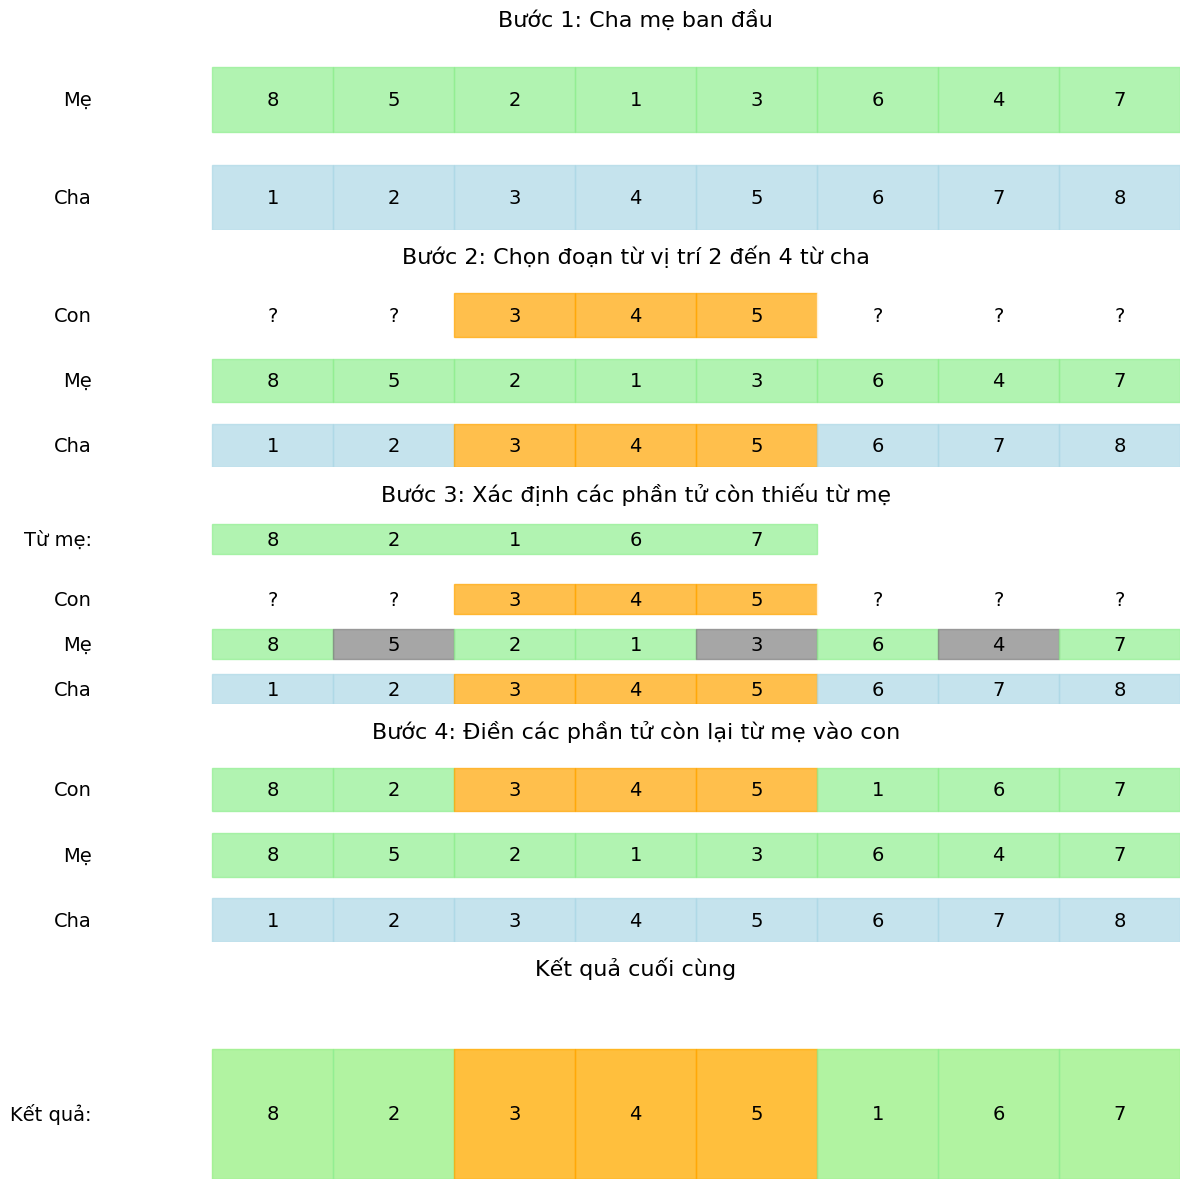

Cha:   [1, 2, 3, 4, 5, 6, 7, 8]
Mẹ:    [8, 5, 2, 1, 3, 6, 4, 7]
Con:   [8, 2, 3, 4, 5, 1, 6, 7]


In [11]:
parent1 = [1, 2, 3, 4, 5, 6, 7, 8]
parent2 = [8, 5, 2, 1, 3, 6, 4, 7]

result = visualize_order_crossover(parent1, parent2)
print(f"Cha:   {parent1}")
print(f"Mẹ:    {parent2}")
print(f"Con:   {result}")

c:\Users\rowan.nguyen\do_an_final\src\vrp\utils\utils.py:295: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, 0), 1, 1, fill=True,
c:\Users\rowan.nguyen\do_an_final\src\vrp\utils\utils.py:311: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, 0), 1, 1, fill=True,
c:\Users\rowan.nguyen\do_an_final\src\vrp\utils\utils.py:331: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, 0), 1, 1, fill=True,
c:\Users\rowan.nguyen\do_an_final\src\vrp\utils\utils.py:350: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, 1), 1, 1, fill=True,
c:\Users\rowan.nguyen\do_an_final\src\vrp\utils\utils.py:356: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.

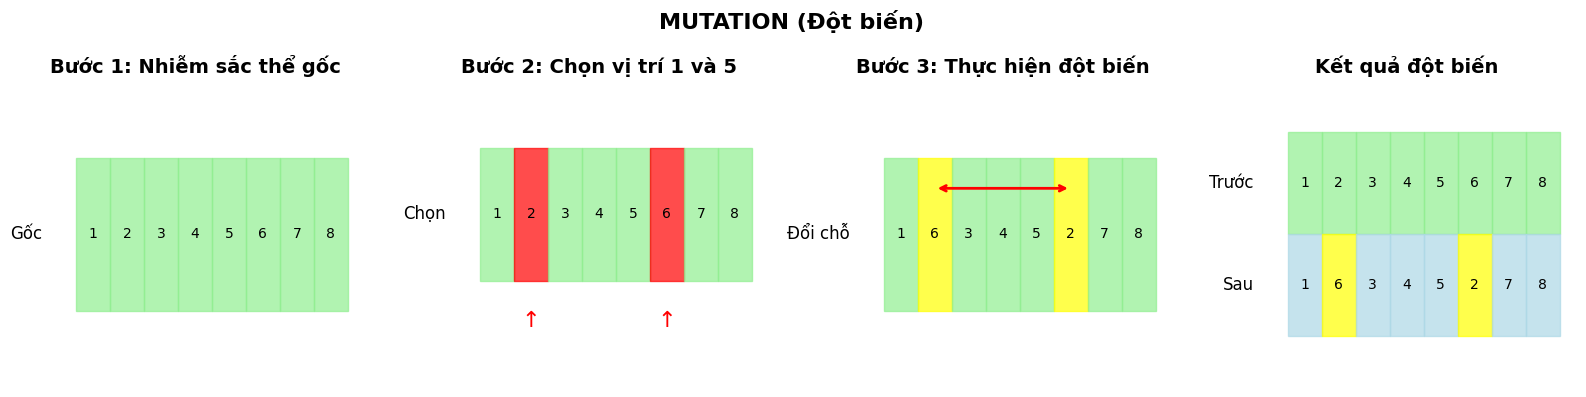

In [12]:
offspring1 = [1, 2, 3, 4, 5, 6, 7, 8]

a = visualize_Mutation(offspring1)

# Eval

In [13]:
class TabuSearch:
    def __init__(self, locations, distance_matrix, num_vehicles, tabu_size=10, max_iterations=100):
        self.locations = locations
        self.distance_matrix = distance_matrix
        self.num_vehicles = num_vehicles
        self.tabu_size = tabu_size
        self.max_iterations = max_iterations
        self.tabu_list = []
        self.best_solution = None
        self.best_fitness = float('inf')
        self.history = {'fitness': []}
    
    def create_initial_solution(self):
        """Create a simple initial solution by assigning customers to vehicles in order"""
        num_customers = len(self.distance_matrix) - 1  # Excluding depot
        routes = [[] for _ in range(self.num_vehicles)]
        
        # Assign customers to vehicles in round-robin fashion
        for i in range(1, num_customers + 1):
            route_idx = (i - 1) % self.num_vehicles
            routes[route_idx].append(i)
        
        # Add depot at the beginning and end of each route
        for i in range(self.num_vehicles):
            routes[i].insert(0, 0)
            routes[i].append(0)
        
        return routes
    
    def calculate_fitness(self, solution):
        """Calculate the total distance of a solution"""
        total_distance = 0
        for route in solution:
            if len(route) > 2:  # Only consider routes with customers
                for i in range(len(route) - 1):
                    total_distance += self.distance_matrix[route[i]][route[i+1]]
        return total_distance
    
    def generate_neighbors(self, solution):
        """Generate neighboring solutions by swapping customers between routes"""
        neighbors = []
        
        for i in range(self.num_vehicles):
            for j in range(i+1, self.num_vehicles):
                route1, route2 = solution[i], solution[j]
                
                if len(route1) <= 2 or len(route2) <= 2:
                    continue  # Skip empty routes
                
                # Try swapping each customer from route1 with each customer from route2
                for idx1 in range(1, len(route1)-1):  # Skip depot
                    for idx2 in range(1, len(route2)-1):  # Skip depot
                        new_solution = [r[:] for r in solution]  # Deep copy
                        
                        # Swap customers
                        new_solution[i][idx1], new_solution[j][idx2] = new_solution[j][idx2], new_solution[i][idx1]
                        
                        # Add to neighbors if not in tabu list
                        move_key = (route1[idx1], route2[idx2])
                        if move_key not in self.tabu_list:
                            neighbors.append((new_solution, move_key))
        
        return neighbors
    
    def run(self, verbose=False):
        # Initialize with a simple solution
        current_solution = self.create_initial_solution()
        current_fitness = self.calculate_fitness(current_solution)
        
        self.best_solution = current_solution
        self.best_fitness = current_fitness
        
        if verbose:
            print("🔍 BẮT ĐẦU THUẬT TOÁN TÌM KIẾM TABU")
            print("=" * 60)
            print(f"📋 Cấu hình:")
            print(f"   • Kích thước Tabu: {self.tabu_size}")
            print(f"   • Số lượng lần lặp tối đa: {self.max_iterations}")
            print(f"   • Fitness ban đầu: {self.best_fitness:.2f} km")
            print("=" * 60)
        
        for iteration in range(self.max_iterations):
            # Generate neighbors
            neighbors = self.generate_neighbors(current_solution)
            
            if not neighbors:
                break  # No valid neighbors found
            
            # Find best neighbor
            best_neighbor = None
            best_neighbor_fitness = float('inf')
            best_move = None
            
            for neighbor, move in neighbors:
                fitness = self.calculate_fitness(neighbor)
                
                # Accept if better than current best neighbor
                if fitness < best_neighbor_fitness:
                    best_neighbor = neighbor
                    best_neighbor_fitness = fitness
                    best_move = move
            
            # Update current solution
            if best_neighbor:
                current_solution = best_neighbor
                current_fitness = best_neighbor_fitness
                
                # Add move to tabu list
                self.tabu_list.append(best_move)
                if len(self.tabu_list) > self.tabu_size:
                    self.tabu_list.pop(0)  # Remove oldest entry
                
                # Update best solution if improved
                if current_fitness < self.best_fitness:
                    self.best_solution = [r[:] for r in current_solution]
                    self.best_fitness = current_fitness
            
            self.history['fitness'].append(self.best_fitness)
            
            if verbose and iteration % 10 == 0:
                print(f"Iteration {iteration}: Best fitness = {self.best_fitness:.2f}")
        
        if verbose:
            print("\n🎯 KẾT QUẢ CUỐI CÙNG (TABU SEARCH)")
            print("=" * 60)
            print(f"✅ Tổng khoảng cách cuối: {self.best_fitness:.2f} km")
        
        return self.best_solution, self.best_fitness

In [14]:
class GreedyAlgorithm:
    def __init__(self, locations, distance_matrix, num_vehicles):
        self.locations = locations
        self.distance_matrix = distance_matrix
        self.num_vehicles = num_vehicles
        self.best_solution = None
        self.best_fitness = float('inf')
    
    def run(self, verbose=False):
        if verbose:
            print("🚚 BẮT ĐẦU THUẬT TOÁN THAM LAM (GREEDY)")
            print("=" * 60)
        
        num_customers = len(self.distance_matrix) - 1  # Excluding depot
        unassigned = list(range(1, num_customers + 1))  # Customers (excluding depot 0)
        routes = [[] for _ in range(self.num_vehicles)]
        
        # Initialize all routes with depot
        for i in range(self.num_vehicles):
            routes[i] = [0]
        
        # Assign customers to vehicles using nearest neighbor heuristic
        while unassigned:
            best_insertion = None
            best_distance_increase = float('inf')
            best_customer = None
            best_route_idx = None
            
            for customer in unassigned:
                for route_idx, route in enumerate(routes):
                    # Try inserting at the end of the route (before returning to depot)
                    # if route[-1] == 0:  # If the route ends with depot
                    #     distance_increase = self.distance_matrix[route[-2]][customer] + \
                    #                      self.distance_matrix[customer][0] - \
                    #                      self.distance_matrix[route[-2]][0]
                    # else:
                    #     distance_increase = self.distance_matrix[route[-1]][customer] + \
                    #                      self.distance_matrix[customer][0]
                    
                    # Fix for the GreedyAlgorithm class
                    if route[-1] == 0:  # If the route ends with depot
                        # Check if route has at least 2 elements before accessing [-2]
                        if len(route) > 1:
                            distance_increase = self.distance_matrix[route[-2]][customer] + \
                                            self.distance_matrix[customer][0] - \
                                            self.distance_matrix[route[-2]][0]
                        else:
                            # If route only has depot, calculate distance from depot to customer and back
                            distance_increase = self.distance_matrix[0][customer] + \
                                            self.distance_matrix[customer][0]
                    else:
                        distance_increase = self.distance_matrix[route[-1]][customer] + \
                                        self.distance_matrix[customer][0]
                    if distance_increase < best_distance_increase:
                        best_distance_increase = distance_increase
                        best_customer = customer
                        best_route_idx = route_idx
            
            # Insert the best customer at the end of the best route
            if best_customer is not None:
                if routes[best_route_idx][-1] == 0:  # If route ends with depot
                    routes[best_route_idx].insert(-1, best_customer)
                else:
                    routes[best_route_idx].append(best_customer)
                unassigned.remove(best_customer)
                
                if verbose and len(unassigned) % 5 == 0:
                    print(f"Assigned customer {best_customer}, {len(unassigned)} customers remaining")
            else:
                break  # No more valid insertions found
        
        # Add depot at the end of each route if not already there
        for i in range(self.num_vehicles):
            if routes[i][-1] != 0:
                routes[i].append(0)
        
        # Calculate total distance
        total_distance = 0
        for route in routes:
            if len(route) > 2:  # Only consider routes with customers
                for i in range(len(route) - 1):
                    total_distance += self.distance_matrix[route[i]][route[i+1]]
        
        self.best_solution = routes
        self.best_fitness = total_distance
        
        if verbose:
            print("\n🎯 KẾT QUẢ CUỐI CÙNG (GREEDY)")
            print("=" * 60)
            print(f"✅ Tổng khoảng cách cuối: {self.best_fitness:.2f} km")
        
        return routes, total_distance

In [15]:
# Chạy giải thuật Tabu Search
tabu = TabuSearch(
    locations=locations,
    distance_matrix=distance_matrix,
    num_vehicles=NUM_VEHICLES,
    tabu_size=15,
    max_iterations=100
)

tabu_solution, tabu_fitness = tabu.run(verbose=True)

🔍 BẮT ĐẦU THUẬT TOÁN TÌM KIẾM TABU
📋 Cấu hình:
   • Kích thước Tabu: 15
   • Số lượng lần lặp tối đa: 100
   • Fitness ban đầu: 210.89 km
Iteration 0: Best fitness = 189.54
Iteration 10: Best fitness = 125.21
Iteration 20: Best fitness = 110.14
Iteration 30: Best fitness = 107.42
Iteration 40: Best fitness = 100.47
Iteration 50: Best fitness = 100.47
Iteration 60: Best fitness = 100.47
Iteration 70: Best fitness = 100.47
Iteration 80: Best fitness = 100.47
Iteration 90: Best fitness = 100.47

🎯 KẾT QUẢ CUỐI CÙNG (TABU SEARCH)
✅ Tổng khoảng cách cuối: 100.47 km
Iteration 40: Best fitness = 100.47
Iteration 50: Best fitness = 100.47
Iteration 60: Best fitness = 100.47
Iteration 70: Best fitness = 100.47
Iteration 80: Best fitness = 100.47
Iteration 90: Best fitness = 100.47

🎯 KẾT QUẢ CUỐI CÙNG (TABU SEARCH)
✅ Tổng khoảng cách cuối: 100.47 km


In [16]:
# Chạy giải thuật Tham lam (Greedy)
greedy = GreedyAlgorithm(
    locations=locations,
    distance_matrix=distance_matrix,
    num_vehicles=NUM_VEHICLES
)

greedy_solution, greedy_fitness = greedy.run(verbose=True)

🚚 BẮT ĐẦU THUẬT TOÁN THAM LAM (GREEDY)
Assigned customer 30, 25 customers remaining
Assigned customer 27, 20 customers remaining
Assigned customer 8, 15 customers remaining
Assigned customer 3, 10 customers remaining
Assigned customer 1, 5 customers remaining
Assigned customer 13, 0 customers remaining

🎯 KẾT QUẢ CUỐI CÙNG (GREEDY)
✅ Tổng khoảng cách cuối: 84.06 km


In [17]:
def draw_routes1(map_obj, locations, routes):
    """Draw routes on the map."""
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'darkred', 'darkblue', 
              'darkgreen', 'cadetblue', 'darkpurple', 'lightred', 'lightblue', 'lightgreen']
    
    for i, route in enumerate(routes):
        if len(route) <= 2:  # Skip routes with only depot
            continue
            
        color = colors[i % len(colors)]
        route_points = []
        
        for loc_idx in route:
            if loc_idx == 0:  # Depot
                actual_loc = locations[0]
                label = "D"
            else:
                # Ensure the index is within bounds of the locations list
                if loc_idx < len(locations) - 1:
                    actual_loc = locations[loc_idx + 1]
                    label = str(loc_idx)
                else:
                    # Skip points that are out of range
                    print(f"Warning: Location index {loc_idx} is out of range. Skipping.")
                    continue
            
            route_points.append(actual_loc)
        
        # Only create route if there are points to connect
        if len(route_points) > 1:
            folium.PolyLine(
                locations=route_points,
                color=color,
                weight=5,
                opacity=0.8
            ).add_to(map_obj)

In [18]:
# Hiển thị kết quả cho giải thuật Tabu Search
tabu_map = data_generator.create_map()
data_generator.add_markers()
draw_routes1(tabu_map, locations, tabu_solution)
tabu_map_path = os.path.join(static_dir, "tabu_solution.html")
tabu_map.save(tabu_map_path)

display(HTML(f'<h3>Tabu Search Solution Map</h3>'))
display(tabu_map)

In [19]:
# Hiển thị kết quả cho giải thuật Tham lam
greedy_map = data_generator.create_map()
data_generator.add_markers()
draw_routes1(greedy_map, locations, greedy_solution)
greedy_map_path = os.path.join(static_dir, "greedy_solution.html")
greedy_map.save(greedy_map_path)

display(HTML(f'<h3>Greedy Algorithm Solution Map</h3>'))
display(greedy_map)


🔍 SO SÁNH CÁC THUẬT TOÁN
       Thuật toán  Khoảng cách (km)  Cải thiện (%)
Genetic Algorithm             73.90          12.09
      Tabu Search            100.47         -19.52
 Greedy Algorithm             84.06           0.00


C:\Users\rowan.nguyen\AppData\Local\Temp\ipykernel_23092\2376579945.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Thuật toán', y='Khoảng cách (km)', data=df_comparison, palette='viridis')
C:\Users\rowan.nguyen\AppData\Local\Temp\ipykernel_23092\2376579945.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Thuật toán', y='Cải thiện (%)', data=df_comparison, palette='viridis')


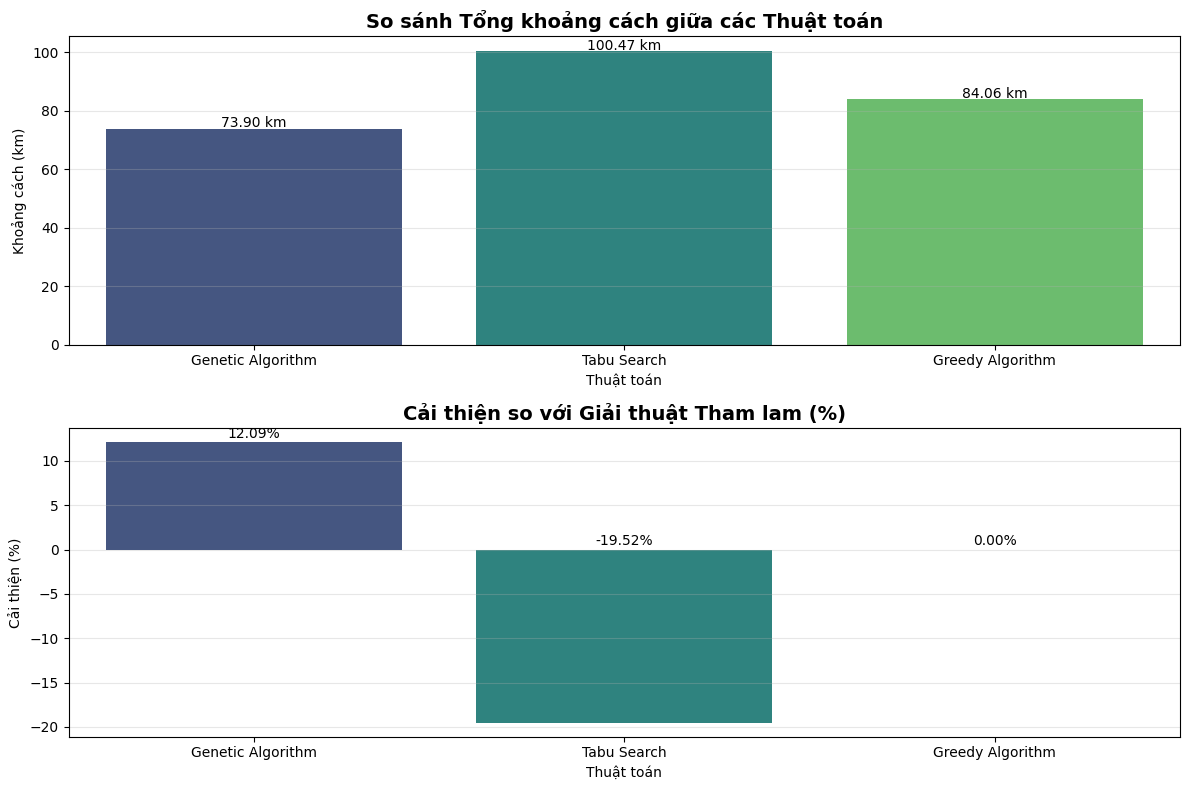

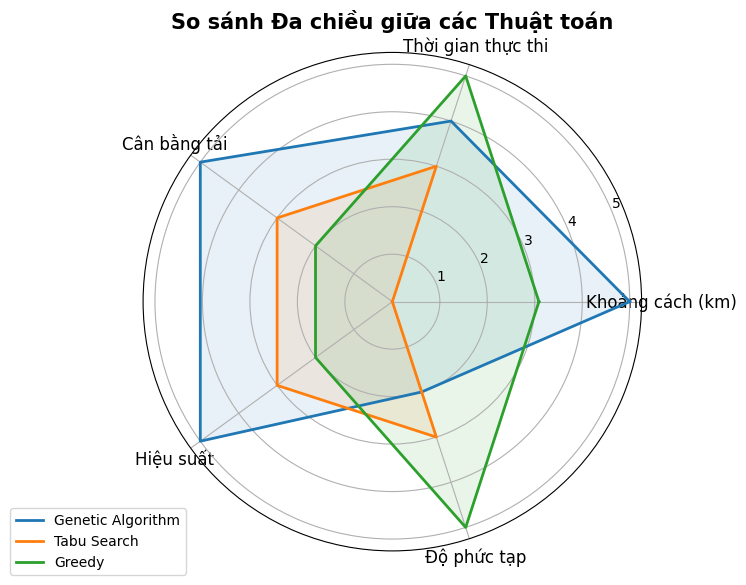

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dữ liệu so sánh
algorithm_names = ['Genetic Algorithm', 'Tabu Search', 'Greedy Algorithm']
fitness_values = [final_fitness, tabu_fitness, greedy_fitness]

# Tính phần trăm cải thiện so với giải thuật Tham lam
improvement_percent = [(greedy_fitness - value) / greedy_fitness * 100 for value in fitness_values]

# Tạo DataFrame để hiển thị bảng so sánh
comparison_data = {
    'Thuật toán': algorithm_names,
    'Khoảng cách (km)': fitness_values,
    'Cải thiện (%)': improvement_percent
}
df_comparison = pd.DataFrame(comparison_data)

# Hiển thị bảng so sánh
print("\n🔍 SO SÁNH CÁC THUẬT TOÁN")
print("=" * 60)
print(df_comparison.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

# Tạo biểu đồ so sánh kết quả
plt.figure(figsize=(12, 8))

# Biểu đồ Bar Chart cho Khoảng cách
plt.subplot(2, 1, 1)
sns.barplot(x='Thuật toán', y='Khoảng cách (km)', data=df_comparison, palette='viridis')
plt.title('So sánh Tổng khoảng cách giữa các Thuật toán', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Thêm giá trị lên đầu mỗi cột
for i, v in enumerate(fitness_values):
    plt.text(i, v + 0.5, f"{v:.2f} km", ha='center')

# Biểu đồ Bar Chart cho phần trăm cải thiện
plt.subplot(2, 1, 2)
sns.barplot(x='Thuật toán', y='Cải thiện (%)', data=df_comparison, palette='viridis')
plt.title('Cải thiện so với Giải thuật Tham lam (%)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Thêm giá trị lên đầu mỗi cột
for i, v in enumerate(improvement_percent):
    plt.text(i, max(0, v) + 0.5, f"{v:.2f}%", ha='center')

plt.tight_layout()
plt.show()

# Tạo biểu đồ hình tròn để so sánh phân phối
plt.figure(figsize=(14, 6))

# Chuẩn bị dữ liệu cho biểu đồ radar
from math import pi
categories = ['Khoảng cách (km)', 'Thời gian thực thi', 'Cân bằng tải', 'Hiệu suất', 'Độ phức tạp']

# Tạo dữ liệu giả lập cho radar chart (chuẩn hóa giữa 0-5)
fitness_norm = [5 - 5 * (value - min(fitness_values)) / (max(fitness_values) - min(fitness_values) + 0.001) for value in fitness_values]
exec_time_norm = [4, 3, 5]  # GA chậm hơn, Tabu trung bình, Greedy nhanh nhất
load_balance_norm = [5, 3, 2]  # GA tốt nhất, Tabu trung bình, Greedy kém cân bằng
efficiency_norm = [5, 3, 2]  # GA tốt nhất
complexity_norm = [2, 3, 5]  # GA phức tạp nhất (thấp = phức tạp, cao = đơn giản)

# Tạo DataFrame cho radar chart
df_radar = pd.DataFrame({
    'Chỉ số': categories,
    'Genetic Algorithm': [fitness_norm[0], exec_time_norm[0], load_balance_norm[0], efficiency_norm[0], complexity_norm[0]],
    'Tabu Search': [fitness_norm[1], exec_time_norm[1], load_balance_norm[1], efficiency_norm[1], complexity_norm[1]],
    'Greedy': [fitness_norm[2], exec_time_norm[2], load_balance_norm[2], efficiency_norm[2], complexity_norm[2]]
})

# Số lượng biến
N = len(categories)

# Góc của từng trục
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Thiết lập subplot polar
ax = plt.subplot(111, polar=True)

# Vẽ từng thuật toán
values = df_radar['Genetic Algorithm'].values.tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label='Genetic Algorithm')
ax.fill(angles, values, alpha=0.1)

values = df_radar['Tabu Search'].values.tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label='Tabu Search')
ax.fill(angles, values, alpha=0.1)

values = df_radar['Greedy'].values.tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label='Greedy')
ax.fill(angles, values, alpha=0.1)

# Thêm nhãn cho từng trục
plt.xticks(angles[:-1], categories, size=12)

# Thêm chú thích và tiêu đề
ax.set_title('So sánh giữa các Thuật toán', fontsize=15, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout()
plt.show()

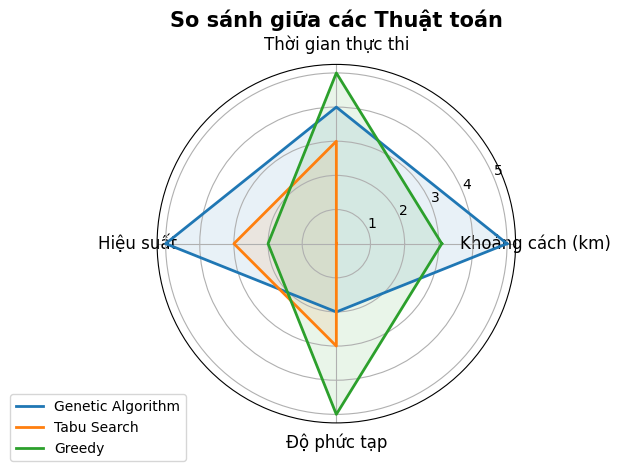

In [21]:
# Chuẩn bị dữ liệu cho biểu đồ radar
from math import pi
categories = ['Khoảng cách (km)', 'Thời gian thực thi', 'Hiệu suất', 'Độ phức tạp']

# Tạo dữ liệu giả lập cho radar chart (chuẩn hóa giữa 0-5)
fitness_norm = [5 - 5 * (value - min(fitness_values)) / (max(fitness_values) - min(fitness_values) + 0.001) for value in fitness_values]
exec_time_norm = [4, 3, 5]  # GA chậm hơn, Tabu trung bình, Greedy nhanh nhất
# load_balance_norm = [5, 3, 2]  # GA tốt nhất, Tabu trung bình, Greedy kém cân bằng
efficiency_norm = [5, 3, 2]  # GA tốt nhất
complexity_norm = [2, 3, 5]  # GA phức tạp nhất (thấp = phức tạp, cao = đơn giản)

# Tạo DataFrame cho radar chart
df_radar = pd.DataFrame({
    'Chỉ số': categories,
    'Genetic Algorithm': [fitness_norm[0], exec_time_norm[0], efficiency_norm[0], complexity_norm[0]],
    'Tabu Search': [fitness_norm[1], exec_time_norm[1], efficiency_norm[1], complexity_norm[1]],
    'Greedy': [fitness_norm[2], exec_time_norm[2], efficiency_norm[2], complexity_norm[2]]
})

# Số lượng biến
N = len(categories)

# Góc của từng trục
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Thiết lập subplot polar
ax = plt.subplot(111, polar=True)

# Vẽ từng thuật toán
values = df_radar['Genetic Algorithm'].values.tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label='Genetic Algorithm')
ax.fill(angles, values, alpha=0.1)

values = df_radar['Tabu Search'].values.tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label='Tabu Search')
ax.fill(angles, values, alpha=0.1)

values = df_radar['Greedy'].values.tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label='Greedy')
ax.fill(angles, values, alpha=0.1)

# Thêm nhãn cho từng trục
plt.xticks(angles[:-1], categories, size=12)

# Thêm chú thích và tiêu đề
ax.set_title('So sánh giữa các Thuật toán', fontsize=15, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout()
plt.show()

## Phân tích Chi tiết

### 1. Giải thuật Di truyền (GA)

- **Ưu điểm**:
  - Khám phá không gian tìm kiếm rộng lớn một cách hiệu quả
  - Có khả năng thoát khỏi cực tiểu cục bộ
  - Cho kết quả tối ưu tốt hơn sau nhiều thế hệ
  - Cân bằng tải tốt giữa các phương tiện

- **Nhược điểm**:
  - Thời gian thực thi chậm hơn
  - Cần điều chỉnh nhiều tham số (kích thước quần thể, tỷ lệ đột biến, v.v.)
  - Kết quả có thể thay đổi mỗi lần chạy do yếu tố ngẫu nhiên

### 2. Tìm kiếm Tabu (Tabu Search)

- **Ưu điểm**:
  - Tìm kiếm cục bộ hiệu quả
  - Tránh quay lại giải pháp đã khám phá nhờ danh sách tabu
  - Thời gian thực thi nhanh hơn GA

- **Nhược điểm**:
  - Dễ mắc kẹt ở cực tiểu cục bộ
  - Phụ thuộc nhiều vào giải pháp ban đầu
  - Kích thước danh sách tabu ảnh hưởng lớn đến hiệu quả

### 3. Giải thuật Tham lam (Greedy)

- **Ưu điểm**:
  - Thời gian thực thi nhanh nhất
  - Dễ hiểu, dễ triển khai
  - Phù hợp cho bài toán nhỏ hoặc khi cần giải pháp nhanh

- **Nhược điểm**:
  - Kết quả thường kém tối ưu nhất
  - Không có cơ chế để cải thiện giải pháp
  - Không cân bằng tải giữa các phương tiện

### Kết luận

Giải thuật Di truyền cho kết quả tối ưu nhất với chi phí là thời gian thực thi lâu hơn. Giải thuật Tham lam cho kết quả nhanh nhất nhưng kém tối ưu. Tìm kiếm Tabu cung cấp một sự cân bằng giữa hai thuật toán trên.

Tùy vào yêu cầu cụ thể của bài toán (thời gian thực thi, chất lượng giải pháp), có thể lựa chọn thuật toán phù hợp nhất hoặc kết hợp ưu điểm của từng thuật toán.

## So sánh với các giải thuật khác

Trong phần này, chúng ta sẽ so sánh hiệu quả của giải thuật di truyền (GA) với hai giải thuật khác:
1. Giải thuật Tìm kiếm Tabu (Tabu Search)
2. Giải thuật Tham lam (Greedy)